# BaarleNet [Part 6c].ipynb

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

def get_relu_joint(weight_1, weight_2, bias, extent=1):
    if np.abs(weight_2) < 1e-8: 
        x_intercept = -bias / weight_1
        return [[x_intercept, -extent], [x_intercept, extent]] if -extent <= x_intercept <= extent else []
    elif np.abs(weight_1) < 1e-8:
        y_intercept = -bias / weight_2
        return [[-extent, y_intercept], [extent, y_intercept]] if -extent <= y_intercept <= extent else []
    else:
        points = []
        for x in [-extent, extent]:
            y = (-x * weight_1 - bias) / weight_2
            if -extent <= y <= extent: points.append([x, y])
        for y in [-extent, extent]:
            x = (-y * weight_2 - bias) / weight_1
            if -extent <= x <= extent: points.append([x, y])
        unique_points = []
        for p in points:
            is_duplicate = False
            for existing in unique_points:
                if abs(p[0] - existing[0]) < 1e-8 and abs(p[1] - existing[1]) < 1e-8:
                    is_duplicate = True
                    break
            if not is_duplicate:
                unique_points.append(p)
        return unique_points

def viz_map_with_predictions(ax, map, X, y):
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    
    X_denorm=denorm(X[:1000,:])
    # plt.scatter(X_denorm[:,0], X_denorm[:,1], c=y[:1000], s=2, alpha=0.8)
    labels=y[:1000]
    y_hat=torch.argmax(model(torch.tensor(X[:1000,:]).float()).detach(),1).numpy()
    tp_mask=np.logical_and(labels==1, y_hat==1)
    fp_mask=np.logical_and(labels==0, y_hat==1)
    fn_mask=np.logical_and(labels==1, y_hat==0)
    tn_mask=np.logical_and(labels==0, y_hat==0)
    ax.scatter(X_denorm[tp_mask,0], X_denorm[tp_mask,1], c='g', s=3, alpha=0.8)
    ax.scatter(X_denorm[fp_mask,0], X_denorm[fp_mask,1], c='r', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[fn_mask,0], X_denorm[fn_mask,1], c='orange', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[tn_mask,0], X_denorm[tn_mask,1], c='purple', marker='o', s=5, alpha=0.8)

def extract_weights_to_numpy(model, layer_indices=None, output_file=None):
    """
    Extract PyTorch model weights and biases to NumPy arrays with copy-paste ready code.
    
    Args:
        model: PyTorch model
        layer_indices: List of layer indices to extract (if None, extracts all layers with weights)
        output_file: Optional file path to save the output code
    
    Returns:
        String containing the NumPy array definitions ready to copy-paste
    """
    
    lines = []
    lines.append("import numpy as np\n")
    
    # Auto-detect layers if not specified
    if layer_indices is None:
        layer_indices = []
        for i, layer in enumerate(model.model):
            if hasattr(layer, 'weight'):
                layer_indices.append(i)
    
    # Extract weights and biases
    weight_counter = 1
    for idx in layer_indices:
        layer = model.model[idx]
        
        if hasattr(layer, 'weight'):
            # Extract weight
            weight_np = layer.weight.detach().numpy()
            weight_repr = np.array2string(weight_np, 
                                        separator=', ', 
                                        formatter={'float_kind': lambda x: f"{x:g}"})
            lines.append(f"w{weight_counter} = np.array({weight_repr}, dtype=np.float32)")
            
            # Extract bias if it exists
            if hasattr(layer, 'bias') and layer.bias is not None:
                bias_np = layer.bias.detach().numpy()
                bias_repr = np.array2string(bias_np, 
                                          separator=', ', 
                                          formatter={'float_kind': lambda x: f"{x:g}"})
                lines.append(f"b{weight_counter} = np.array({bias_repr}, dtype=np.float32)")
            
            weight_counter += 1
    
    output = '\n'.join(lines)
    
    # Save to file if specified
    if output_file:
        with open(output_file, 'w') as f:
            f.write(output)
        print(f"Weights saved to {output_file}")
    
    # Print to console
    print(output)
    return output

def extract_specific_layers(model, layer_specs):
    """
    Extract specific layers with custom naming.
    
    Args:
        model: PyTorch model
        layer_specs: List of tuples (layer_index, weight_name, bias_name)
                    e.g., [(0, 'w1', 'b1'), (2, 'w2', 'b2')]
    
    Returns:
        String containing the NumPy array definitions
    """
    
    lines = []
    lines.append("import numpy as np\n")
    
    for layer_idx, weight_name, bias_name in layer_specs:
        layer = model.model[layer_idx]
        
        if hasattr(layer, 'weight'):
            # Extract weight
            weight_np = layer.weight.detach().numpy()
            weight_repr = np.array2string(weight_np, 
                                        separator=', ', 
                                        formatter={'float_kind': lambda x: f"{x:g}"})
            lines.append(f"{weight_name} = np.array({weight_repr}, dtype=np.float32)")
            
            # Extract bias if it exists and bias_name is provided
            if bias_name and hasattr(layer, 'bias') and layer.bias is not None:
                bias_np = layer.bias.detach().numpy()
                bias_repr = np.array2string(bias_np, 
                                          separator=', ', 
                                          formatter={'float_kind': lambda x: f"{x:g}"})
                lines.append(f"{bias_name} = np.array({bias_repr}, dtype=np.float32)")
    
    output = '\n'.join(lines)
    print(output)
    return output

In [3]:
def get_second_layer_boundaries(model, extent=1):
    """
    Analytically solve for second layer ReLU boundaries
    Returns list of line segments for each second layer neuron
    """
    
    # Get layer weights and biases
    W1 = model.model[0].weight.detach().numpy()  # Shape: (2, 2)
    b1 = model.model[0].bias.detach().numpy()    # Shape: (2,)
    W2 = model.model[2].weight.detach().numpy()  # Shape: (2, 2) 
    b2 = model.model[2].bias.detach().numpy()    # Shape: (2,)
    
    # First, get the first layer ReLU boundaries
    first_layer_boundaries = []
    for i in range(2):
        boundary = get_relu_joint(W1[i,0], W1[i,1], b1[i], extent)
        first_layer_boundaries.append(boundary)
    
    # Define the regions created by first layer boundaries
    # Each region is defined by which first layer neurons are active
    regions = [
        (False, False),  # Both neurons off
        (True, False),   # First neuron on, second off
        (False, True),   # First neuron off, second on  
        (True, True)     # Both neurons on
    ]
    
    second_layer_boundaries = []
    
    # For each second layer neuron
    for neuron_idx in range(2):
        neuron_boundaries = []
        
        # For each region defined by first layer
        for region_mask in regions:
            # In this region, the second layer pre-activation is:
            # h2_pre = W2[neuron_idx, 0] * (W1[0,:] * x + b1[0]) * region_mask[0] + 
            #          W2[neuron_idx, 1] * (W1[1,:] * x + b1[1]) * region_mask[1] + 
            #          b2[neuron_idx]
            
            # Collect active terms
            active_weight = np.zeros(2)  # Coefficients for [x, y]
            active_bias = b2[neuron_idx]
            
            for i in range(2):
                if region_mask[i]:  # If this first layer neuron is active
                    active_weight += W2[neuron_idx, i] * W1[i, :]
                    active_bias += W2[neuron_idx, i] * b1[i]
            
            # Now solve: active_weight[0] * x + active_weight[1] * y + active_bias = 0
            boundary = get_relu_joint(active_weight[0], active_weight[1], active_bias, extent)
            
            if boundary:
                # Check if this boundary segment is actually within the region
                # We need to verify that the boundary points satisfy the region constraints
                valid_segments = []
                
                for seg_start, seg_end in zip(boundary[:-1], boundary[1:]):
                    # Check if segment is within the region defined by first layer
                    # Sample a point in the middle of the segment
                    mid_point = [(seg_start[0] + seg_end[0])/2, (seg_start[1] + seg_end[1])/2]
                    
                    # Check if this point satisfies the region constraints
                    point_in_region = True
                    for i in range(2):
                        first_layer_activation = W1[i,0] * mid_point[0] + W1[i,1] * mid_point[1] + b1[i]
                        is_active = first_layer_activation > 0
                        if is_active != region_mask[i]:
                            point_in_region = False
                            break
                    
                    if point_in_region:
                        valid_segments.append([seg_start, seg_end])
                
                neuron_boundaries.extend(valid_segments)
        
        second_layer_boundaries.append(neuron_boundaries)
    
    return second_layer_boundaries

def plot_second_layer_boundaries_analytical(ax, model):
    """Plot analytically computed second layer boundaries"""
    
    boundaries = get_second_layer_boundaries(model)
    
    colors = ['red', 'blue']
    for neuron_idx, neuron_boundaries in enumerate(boundaries):
        for segment in neuron_boundaries:
            if len(segment) == 2:  # Valid line segment
                seg_denorm = denorm(np.array(segment))
                ax.plot([seg_denorm[0][0], seg_denorm[1][0]], 
                       [seg_denorm[0][1], seg_denorm[1][1]], 
                       color=colors[neuron_idx], linewidth=2, alpha=0.8,
                       linestyle='dashed', label=f'Layer 2 Neuron {neuron_idx}')

# Simpler version that focuses on the boundary intersections
def get_second_layer_boundaries_simple(model, extent=1):
    """
    Simplified approach: compute boundary in each quadrant defined by first layer
    """
    W1 = model.model[0].weight.detach().numpy()
    b1 = model.model[0].bias.detach().numpy()
    W2 = model.model[2].weight.detach().numpy()
    b2 = model.model[2].bias.detach().numpy()
    
    boundaries = []
    
    # For each second layer neuron
    for neuron_idx in range(2):
        neuron_boundaries = []
        
        # Sample points in a grid and find where the second layer neuron crosses zero
        # But do it analytically by solving the piecewise linear equation
        
        # The key insight: in each region, the equation is linear
        # Region 1: both first layer neurons off
        # h2 = b2[neuron_idx]
        # This gives no boundary unless b2[neuron_idx] = 0
        
        # Region 2: first neuron on, second off  
        # h2 = W2[neuron_idx,0] * (W1[0,0]*x + W1[0,1]*y + b1[0]) + b2[neuron_idx]
        # Set to 0 and solve for the line
        if True:  # Always try this region
            w_eff = W2[neuron_idx, 0] * W1[0, :]
            b_eff = W2[neuron_idx, 0] * b1[0] + b2[neuron_idx]
            boundary = get_relu_joint(w_eff[0], w_eff[1], b_eff, extent)
            if boundary:
                neuron_boundaries.append(boundary)
        
        # Region 3: first neuron off, second on
        if True:
            w_eff = W2[neuron_idx, 1] * W1[1, :]
            b_eff = W2[neuron_idx, 1] * b1[1] + b2[neuron_idx]
            boundary = get_relu_joint(w_eff[0], w_eff[1], b_eff, extent)
            if boundary:
                neuron_boundaries.append(boundary)
        
        # Region 4: both neurons on
        if True:
            w_eff = W2[neuron_idx, 0] * W1[0, :] + W2[neuron_idx, 1] * W1[1, :]
            b_eff = W2[neuron_idx, 0] * b1[0] + W2[neuron_idx, 1] * b1[1] + b2[neuron_idx]
            boundary = get_relu_joint(w_eff[0], w_eff[1], b_eff, extent)
            if boundary:
                neuron_boundaries.append(boundary)
        
        boundaries.append(neuron_boundaries)
    
    return boundaries

# Usage:
def plot_all_boundaries(ax, model):
    """Plot both first and second layer boundaries"""
    
    # First layer (solid lines)
    for neuron_idx in range(2):
        w1 = model.model[0].weight[neuron_idx, 0].item()
        w2 = model.model[0].weight[neuron_idx, 1].item()
        b = model.model[0].bias[neuron_idx].item()
        
        joint = get_relu_joint(w1, w2, b, extent=1)
        if joint:
            joint_denorm = denorm(np.array(joint))
            ax.plot([joint_denorm[0][0], joint_denorm[1][0]], 
                   [joint_denorm[0][1], joint_denorm[1][1]], 
                   color=f'C{neuron_idx}', linewidth=2, alpha=0.8,
                   label=f'Layer 1 Neuron {neuron_idx}')
    
    # Second layer (dashed lines)
    plot_second_layer_boundaries_analytical(ax, model)

In [4]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<50
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

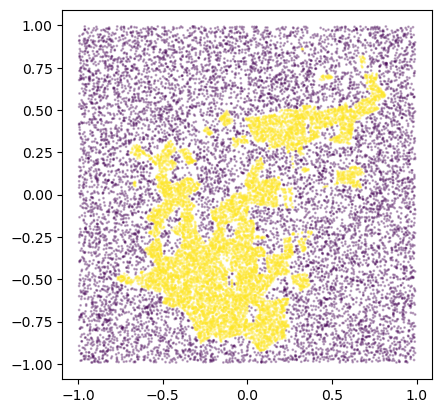

In [5]:
plt.scatter(X[:,0], X[:,1], c=y, s=1, alpha=0.3); plt.axis('square');

In [6]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

 ## ALOT ALOT
 

In [7]:
# # random_seed = 36
# num_neurons = 10000
# batch_size = 32  # Adjust batch size as needed

# accuracies=[]
# for random_seed in range(31, 64):
#     torch.manual_seed(random_seed)  
#     X_tensor = torch.FloatTensor(X)
#     y_tensor = torch.tensor(y)
    
#     # Create dataset and dataloader for minibatching
#     dataset = TensorDataset(X_tensor, y_tensor)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
#     # Initialize model and optimizer
#     model = BaarleNet([num_neurons])
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.005)
#     num_epochs = 20
    
#     for epoch in range(num_epochs):
#         epoch_loss = 0.0
#         num_batches = 0
        
#         for batch_X, batch_y in dataloader:
#             # Forward pass
#             outputs = model(batch_X)
#             loss = criterion(outputs, batch_y)
            
#             # Backward and optimize
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             epoch_loss += loss.item()
#             num_batches += 1
        

#     with torch.no_grad():
#         outputs_batch = model(X_tensor)
#         accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
#     print(f'Random Seed [{random_seed}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

In [8]:
device='cuda'

In [9]:
random_seed = 55 #31
num_neurons = 100000
batch_size = 32  # Adjust batch size as needed

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([num_neurons]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)
num_epochs = 30000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 200) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_tensor.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor.to(device)).sum().item() / len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [150/30000], Loss: 0.1505, Accuracy: 0.9493
Epoch [300/30000], Loss: 0.1413, Accuracy: 0.9587
Epoch [450/30000], Loss: 0.1288, Accuracy: 0.9332
Epoch [600/30000], Loss: 0.1287, Accuracy: 0.9495
Epoch [750/30000], Loss: 0.1179, Accuracy: 0.9526
Epoch [900/30000], Loss: 0.1225, Accuracy: 0.9562
Epoch [1050/30000], Loss: 0.1140, Accuracy: 0.9657
Epoch [1200/30000], Loss: 0.1136, Accuracy: 0.9649
Epoch [1350/30000], Loss: 0.1061, Accuracy: 0.9558
Epoch [1500/30000], Loss: 0.1077, Accuracy: 0.9573
Epoch [1650/30000], Loss: 0.1008, Accuracy: 0.9689
Epoch [1800/30000], Loss: 0.1010, Accuracy: 0.9702
Epoch [1950/30000], Loss: 0.0994, Accuracy: 0.9599
Epoch [2100/30000], Loss: 0.0914, Accuracy: 0.9710
Epoch [2250/30000], Loss: 0.0996, Accuracy: 0.9673
Epoch [2400/30000], Loss: 0.0908, Accuracy: 0.9680
Epoch [2550/30000], Loss: 0.0954, Accuracy: 0.9734
Epoch [2700/30000], Loss: 0.0934, Accuracy: 0.9677
Epoch [2850/30000], Loss: 0.0907, Accuracy: 0.9701
Epoch [3000/30000], Loss: 0.0848, Acc

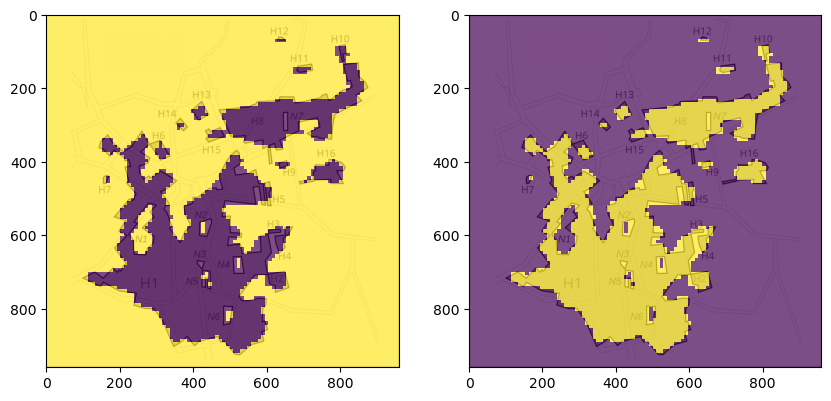

In [16]:
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

h2 = model.model[:3](torch.tensor(probe).to(device).float())
h2 = h2.detach().cpu().numpy().reshape(100,100,2)

fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(h2[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
# plt.savefig(save_dir+str(num_neurons)+'/random_seed_'+str(random_seed)+'.png')

In [ ]:
# _=extract_weights_to_numpy(model, output_file='one_layer_alot_nuerons.py')

In [11]:
torch.save(model,  'one_layer_100k_neurons_long.pt')